In [3]:
import numpy as np
import pandas as pd
import h5py

C:\Users\Sayantan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
f=h5py.File('C:/Users/Sayantan/Downloads/train_catvnoncat.h5', 'r')
###this is a h5 file i.e a file in HDF(Hierarchical Data Format). we are reading this file in read mode, so 'r'

In [5]:
list(f.keys())

['list_classes', 'train_set_x', 'train_set_y']

In [6]:
###list(f.keys()) lists out all the datasets present in the h5 file. Since it is a h5 file,it contains multiple datasets
train_x_orig=np.array(f["train_set_x"][:])
#f["train_set_x"][:] means we are taking all the values of the train_set_x dataset from f file and storing it in train_x_orig
#train_set_x contains the training set features
train_y_orig=np.array(f["train_set_y"][:])
#same for train_y_orig. train_y_orig contains the training set label, X means features and y means label


In [7]:
f1=h5py.File('C:/Users/Sayantan/Downloads/test_catvnoncat.h5','r')

In [8]:
list(f1.keys())

['list_classes', 'test_set_x', 'test_set_y']

In [9]:
test_x_orig=np.array(f1["test_set_x"][:])
#test_x_orig contains the test set features
test_y_orig=np.array(f1["test_set_y"][:])
#test_y_orig contains the test set label

In [10]:
print(train_x_orig.shape)

(209, 64, 64, 3)


In [11]:
#train_x_orig is a 4 dimensional numpy array whose dimensions are the :
#1. id of each training example. no.of ids denote the no. of training examples
#2. the image is represented as a 3d array whose dimensions are(height, width, no.of channels)
#in case of coloured image, we always take 3 channels:blue,green and red(BGR). and both height and width=no. of pixels
#so here train_x_orig.shape[0] is the no. of training examples i.e 209
#height of each image =train_x_orig.shape[1]=64=width of each image=train_x_orig.shape[2]
#train_x_orig.shape[3]=3 always s in case of coloured image we always use 3 channels (BGR)

In [11]:
classes=np.array(f["list_classes"][:])

In [12]:
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline

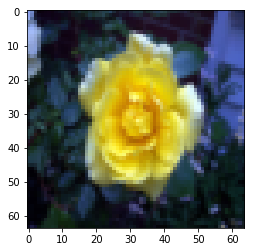

In [15]:
plt.imshow(train_x_orig[34])

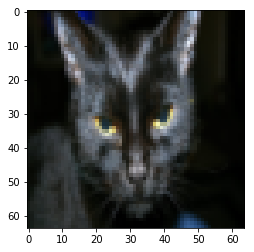

In [13]:
plt.imshow(train_x_orig[25])

In [14]:
train_y_orig = train_y_orig.reshape((1, train_y_orig.shape[0]))
test_y_orig = test_y_orig.reshape((1, test_y_orig.shape[0]))

In [21]:
print ("y = " + str(train_y_orig[:, 25]) + ", it's a '" + classes[np.squeeze(train_y_orig[:, 25])].decode("utf-8") +  "' picture.")

y = [1], it's a 'cat' picture.


In [22]:
m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = train_x_orig.shape[1]
#m_train is no. of training examples, m_test is no. of test examples and num_px is the height and width for each image. here 
#every image is considered to be a square of same size

In [23]:
#For convenience, you should now reshape train_x_orig of shape (m_train,num_px, num_px, 3) in a numpy-array of shape 
#(num_px* num_px* 3, m_train). After this, our training  dataset is a numpy-array where each column represents 
#a flattened image. There should be m_train columns. same goes for test_x_orig

#A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b∗c*d, a) is to use:

#X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

In [24]:
train_x_flat=train_x_orig.reshape(train_x_orig.shape[0], -1).T 
test_x_flat=test_x_orig.reshape(test_x_orig.shape[0], -1).T 
print ("train_x_flat shape: " + str(train_x_flat.shape))
print ("train_y_orig shape: " + str(train_y_orig.shape))
print ("test_x_flat shape: " + str(test_x_flat.shape))
print ("test_y_orig shape: " + str(test_y_orig.shape))


train_x_flat shape: (12288, 209)
train_y_orig shape: (1, 209)
test_x_flat shape: (12288, 50)
test_y_orig shape: (1, 50)


In [25]:
#train_x_flat shape is (64*64*3, 209) i.e (12288,209). so in train_x_flat each coloumn contains the 3d image and there are 209 coloumns i.e 209 images

In [26]:
#One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the 
#mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array
#But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset 
#by 255 (the maximum value of a pixel channel). so lets standarise the dataset.

In [27]:
train_x = train_x_flat/255.
test_x = test_x_flat/255.

In [28]:
def sigmoid(z):
     s = 1/(1+np.exp(-z))
     return s

In [30]:
def propagate(w, b, X, Y): 
    m = X.shape[1]
    
    # FORWARD PROPAGATION 
    A = sigmoid(np.dot(w.T,X)+b)                                 # compute activation
    cost =(-1/m)*np.sum(Y * np.log(A)+(1-Y) * np.log(1-A))   # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot(X,(A-Y).T)
    db = (1/m)*np.sum(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [31]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
      costs = []
      for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        # update rule 
        w = w-learning_rate*dw
        b = b-learning_rate*db
        params = {"w": w,
              "b": b}
    
        grads = {"dw": dw,
             "db": db}
    
        return params, grads, costs

In [52]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    # Compute vector "h" predicting the probabilities of a cat being present in the picture
    h = sigmoid(np.dot(w.T,X)+b)
    for i in range(h.shape[1]):
        if(h[0,i]>0.5):
            Y_prediction[0,i]=1
        else:
            Y_prediction[0,i]=0
    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [60]:
def model(train_x, train_y_orig, test_x, test_y_orig, num_iterations = 3000, learning_rate = 0.6, print_cost = False):
     w=np.zeros((train_x.shape[0],1))
     b=0
     parameters, grads, costs = optimize(w, b, train_x, train_y_orig, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
     w = parameters["w"]
     b = parameters["b"]
    
    # Predict test/train set examples 
     
     Y_prediction_test = predict(w, b, test_x)
     Y_prediction_train = predict(w, b, train_x)

    # Print train/test Errors
     print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - train_y_orig)) * 100))
     print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - test_y_orig)) * 100))
     d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
     return d   

In [61]:
d = model(train_x, train_y_orig, test_x, test_y_orig, num_iterations = 3000, learning_rate = 0.6, print_cost = True)

train accuracy: 65.55023923444976 %
test accuracy: 34.0 %
